In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import math

from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8163481674269158591
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10083106816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1330109661895873740
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

(370, 320) (185, 160)


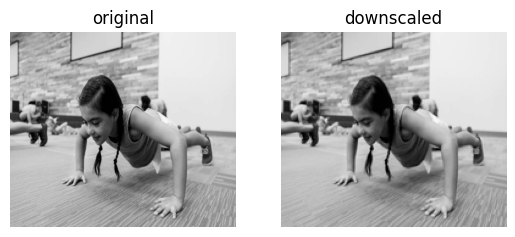

In [3]:
gray_imgs = []
downscaled_imgs = []

for filename in os.listdir('data'):
  img = Image.open(f"data/{filename}").convert('L')
  w, h = img.size
  dimg = img.resize((w//2, h//2))
  gray_imgs.append(img)
  downscaled_imgs.append(dimg)

figure, axis = plt.subplots(1, 2)
axis[0].imshow(gray_imgs[0], cmap='gray', vmin=0, vmax=255)
axis[0].set_title('original')
axis[0].axis('off')
axis[1].imshow(downscaled_imgs[0], cmap='gray', vmin=0, vmax=255)
axis[1].set_title('downscaled')
axis[1].axis('off')

print(gray_imgs[0].size, downscaled_imgs[0].size)

In [4]:
w, h = downscaled_imgs[0].size
l = len(downscaled_imgs)
x_data = np.empty((l, h, w))

for i, img in enumerate(downscaled_imgs):
  x_data[i] = np.array(img)

x_data = x_data / 255
print(x_data[0].shape)

w, h = gray_imgs[0].size
l = len(gray_imgs)
y_data = np.empty((l, h, w))

for i, img in enumerate(gray_imgs):
  y_data[i] = np.array(img)

y_data = y_data / 255
print(y_data[0].shape)

(160, 185)
(320, 370)


In [7]:
tf.device('/device:GPU:0')

model = tf.keras.Sequential([
  tf.keras.layers.UpSampling2D((2, 2), input_shape=(*x_data[0].shape, 1)),
  tf.keras.layers.Conv2D(64, (9, 9), padding="same", activation='relu'),
  tf.keras.layers.Conv2D(32, (5, 5), padding="same", activation='relu'),
  tf.keras.layers.Conv2D(1, (5, 5), padding="same", activation='linear')
])

model.compile(
  optimizer='adam',
  loss='mse',
  metrics=['mse']
)

model.summary()

hist = model.fit(x_data[:300], y_data[:300], epochs=200)
model.evaluate(x_data[300:], y_data[300:])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_2 (UpSampling  (None, 320, 370, 1)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 320, 370, 64)      5248      
                                                                 
 conv2d_7 (Conv2D)           (None, 320, 370, 32)      51232     
                                                                 
 conv2d_8 (Conv2D)           (None, 320, 370, 1)       801       
                                                                 
Total params: 57,281
Trainable params: 57,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 [==============================] - 5s 410ms/step - loss: 0.0939 - mse: 0.0939
Epoch 2/200
10/10 [=

[0.0005115483072586358, 0.0005115483072586358]

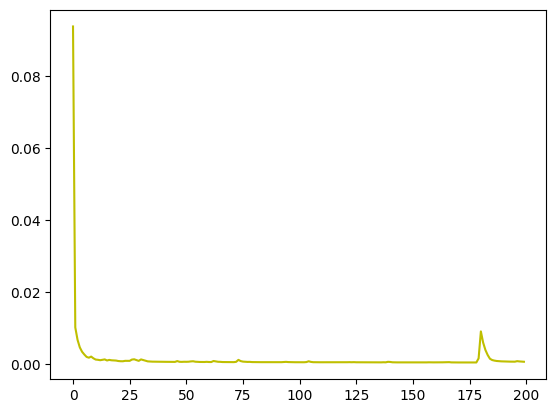

In [8]:
figure, axis = plt.subplots()

axis.plot(hist.history['loss'], 'y', label='train_loss')

[[183 191 209 ... 203 141 109]
 [225 237 230 ... 221 171 156]
 [244 268 259 ... 245 215 195]
 ...
 [261 267 242 ... 259 264 229]
 [232 277 258 ... 270 277 221]
 [183 286 305 ... 258 227 167]] (320, 370)
<class 'numpy.ndarray'>


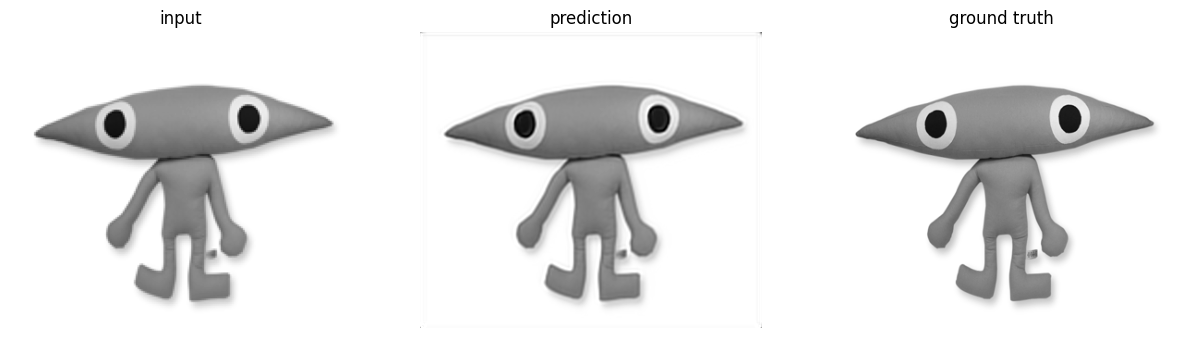

In [15]:
origin = Image.open('test.png').convert('L')
truth = origin.resize((370, 320))
test_img = origin.resize((370//2, 320//2))

input_data = np.empty((1, 320//2, 370//2))
input_data[0] = np.array(test_img)
input_data /= 255

pred = model(input_data)

figure, axis = plt.subplots(1, 3)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0].imshow(input_data[0] * 255, cmap='gray', vmin=0, vmax=255)
axis[0].set_title('input')
axis[0].axis('off')
axis[1].imshow(pred[0] * 255, cmap='gray', vmin=0, vmax=255)
axis[1].set_title('prediction')
axis[1].axis('off')
axis[2].imshow(truth, cmap='gray', vmin=0, vmax=255)
axis[2].set_title('ground truth')
axis[2].axis('off')

gray_pred = pred[0].numpy()
gray_pred = gray_pred * 255
gray_pred = gray_pred.astype(int).reshape((320, 370))
print(gray_pred, gray_pred.shape)
print(type(gray_pred))
pred_img = Image.fromarray(gray_pred)
pred_img.show()
pred_img.convert('RGB').save('pred.png')

In [18]:
import time

start = time.time()
pred = model(input_data)
end = time.time()

print(1/(end - start))

249.4085746565975


: 